<a href="https://colab.research.google.com/github/Rey1380/WavLM/blob/main/WavLM_base%2B_noisy_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WavLM-base+ for speaker verification task on noisy data

The main idea of this notebook comes from: https://huggingface.co/docs/transformers/model_doc/wavlm#transformers.WavLMForXVector
which it has been developed to meet our purpose
    

**WavLM Model with an XVector feature extraction head on top for tasks like Speaker Verification.**

WavLM was proposed in WavLM: Unified Speech Representation Learning with Labeled and Unlabeled Data by Chengyi Wang, Yu Wu, Yao Qian, Kenichi Kumatani, Shujie Liu, Furu Wei, Michael Zeng, Xuedong Huang.(https://arxiv.org/abs/2101.07597)

This model inherits from PreTrainedModel (https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/model#transformers.PreTrainedModel). Check the superclass documentation for the generic methods the library implements for all its model (such as downloading or saving etc.).

This model is a PyTorch torch.nn.Module (https://pytorch.org/docs/stable/nn.html#torch.nn.Module) sub-class. Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and behavior.


### Prerequisites

In [ ]:
!pip install  transformers 
!pip install --quiet datasets
!pip install pycm==3.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
import torch
import librosa
import IPython.display as ipd
import numpy as np

#Define a function for mixing an audio signal with another audio signal(in this project with noise signal)

In [ ]:
def mix_audio(signal, noise, snr):
    # if the audio is longer than the noise
    # play the noise in repeat for the duration of the audio
    noise = noise[np.arange(len(signal)) % len(noise)]
    
    # if the audio is shorter than the noise
    # this is important if loading resulted in 
    # uint8 or uint16 types, because it would cause overflow
    # when squaring and calculating mean
    noise = noise.astype(np.float32)
    signal = signal.astype(np.float32)
    
    # get the initial energy for reference
    signal_energy = np.mean(signal**2)
    noise_energy = np.mean(noise**2)
    # calculates the gain to be applied to the noise 
    # to achieve the given SNR
    g = np.sqrt(10.0 ** (-snr/10) * signal_energy / noise_energy)
    
    # Assumes signal and noise to be decorrelated
    # and calculate (a, b) such that energy of 
    # a*signal + b*noise matches the energy of the input signal
    a = np.sqrt(1 / (1 + g**2))
    b = np.sqrt(g**2 / (1 + g**2))
    print(g, a, b)
    # mix the signals
    return a * signal + b * noise

#loading noise audio signal

In [ ]:
noise,sr=librosa.load("/home/sadeghi/WavLM/noise-sound-bible-0061.wav")

# Loading Enrollment data and adding noise with 15 decibel snr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


here we use 30 speakers from Farsdat dataset!

we choose 10 speakers for test as unknows and the rest of speakers as known(target/untarget)

each speakers has 10 audio files we use the first audio file as Enrollment file

** audio files should be 6 secs (here we use ffmpeg to cut them)**

In [ ]:
import os
spk2spch = {}
PATH = "/home/sadeghi/WavLM/farsdot_enrollment_6_secs/" #enrollment data directory
for fname in next(os.walk(PATH))[2]:
    spk_id, _ = fname.split("F")
    speech_array, sample_rate = librosa.load(PATH + fname) #load data
    speech_array= mix_audio(speech_array,noise,5)#mix loaded audio signal with noise signal with 15 decibel snr
    speech_array = speech_array.squeeze().astype(np.float)
    speech_array = librosa.resample(np.array(speech_array), sample_rate, 16000) #again we have to upsample our files to 16000 Hz in order to prepate data to the model
    
    spk2spch[f"spk-{spk_id}"] = speech_array #split data with spk_id and assign to the corresponding array
print(spk2spch)

0.533569690691615 0.8822663393305893 0.470750577784246


/tmp/ipykernel_274802/1663910857.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  speech_array = speech_array.squeeze().astype(np.float)


0.6855178171392667 0.8248044249615194 0.565418128966429
0.48423162058429003 0.9000319460656288 0.4358239278209917


/tmp/ipykernel_274802/1663910857.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  speech_array = speech_array.squeeze().astype(np.float)


0.9752774254743826 0.7159008596309462 0.6982019472757666
0.5210877687553943 0.8868216230472422 0.4621119008377248
0.9139000181473619 0.7381705808084968 0.6746141071967339
0.3590970865133723 0.9411579346964195 0.337967072298427
0.6401973631007999 0.8421959243485132 0.539171609982159
0.7577815822225646 0.7970131815443828 0.6039619097629425
0.3475105189636519 0.9445892501891606 0.3282547005407221
0.5499428574580001 0.8762370508098569 0.48188030753294353
0.436623239074973 0.9164521458685982 0.400144304386357
0.8373570356170652 0.7667019187716112 0.6420032459045123
0.5054035481499011 0.892489825377097 0.45106752443327036
0.5189801405669063 0.8875870372140209 0.46064004533869646
0.5586830362783911 0.8729957064264651 0.48772789192433647
0.6236602184457022 0.8485088387290977 0.5291812077148982
0.4129027774683524 0.9243073077313353 0.38164905459656345
0.883375191170657 0.7494576461588474 0.6620522914498823
0.5130871415096201 0.8897211204288432 0.4565044664215716
0.6507932014906294 0.83813970475

# Importing WavLM Model and Wav2vec2 Feature extractor 

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, XLSR-Wav2Vec2 models should **always** make use of the `attention_mask`.



In [ ]:
# audio file is decoded on the fly
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("/home/sadeghi/WavLM") #model directory
model = WavLMForXVector.from_pretrained("/home/sadeghi/WavLM") #model directory
threshold = 0.957 #threshold for similarities  # the optimal threshold is dataset-dependent
similarities = [] 

# Getting Results (cosine similarity-based retrieval)

In [ ]:
from os.path import exists

with open('/home/sadeghi/WavLM/farsdot/trials') as f:#trials directory(consist of: spk-ids utt-ids target/nontarget)
    for line in f:
        line = line.strip()
        spk_id, utt_id, target_nontarget = line.split()
        path = "/home/sadeghi/WavLM/farsdot/"  + utt_id.split("-")[1] + ".wav.wav" #wavfiles directory
        if exists(path) is False:
            path = "/home/sadeghi/WavLM/farsdot/"  + utt_id.split("-")[1] + ".WAV.WAV"
        
        speech_array2, sample_rate =librosa.load(path)
        speech_array2=mix_audio(speech_array2,noise,5)
        print(path, spk_id, target_nontarget)
        speech_array2 = speech_array2.squeeze().astype(float)
        speech_array2 = librosa.resample(np.array(speech_array2), sample_rate, 16000)
        speech3 = [spk2spch[spk_id], speech_array2]
        
        inputs= feature_extractor(
            speech3,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True)

        with torch.no_grad():
            embeddings = model(**inputs).embeddings
# the resulting embeddings can be used for cosine similarity-based retrieval
        embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
        cosine_sim = torch.nn.CosineSimilarity(dim=-1)
        similarity = cosine_sim(embeddings[0], embeddings[1])
        similarities.append(similarity.item())
        print(similarity.item())

1.0953124040929796 0.6742444157751256 0.7385082719889193
/home/sadeghi/WavLM/farsdot/001F02.WAV.WAV spk-001 target


/home/sadeghi/anaconda3/lib/python3.9/site-packages/transformers/models/wavlm/modeling_wavlm.py:1809: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


0.9610463976860046
1.0866801436467666 0.6771497757182542 0.7358452155478882
/home/sadeghi/WavLM/farsdot/001F03.WAV.WAV spk-001 target
0.9555569291114807
1.0392872004267115 0.6933555974338741 0.7205955977572411
/home/sadeghi/WavLM/farsdot/001F04.WAV.WAV spk-001 target
0.9609700441360474
1.07658701201443 0.6805651348499164 0.7326875850092692
/home/sadeghi/WavLM/farsdot/001F05.WAV.WAV spk-001 target
0.9738397002220154
0.9880719618663342 0.7113364787704325 0.7028516301257912
/home/sadeghi/WavLM/farsdot/001F06.WAV.WAV spk-001 target
0.9371970891952515
0.9175658128073396 0.7368240460666805 0.6760845547251663
/home/sadeghi/WavLM/farsdot/001F07.WAV.WAV spk-001 target
0.9697823524475098
1.1202993724112962 0.6659167215884655 0.7460260852737458
/home/sadeghi/WavLM/farsdot/001F08.WAV.WAV spk-001 target
0.9480177760124207
0.8792926760746571 0.7509768938074171 0.6603284826261574
/home/sadeghi/WavLM/farsdot/001F09.WAV.WAV spk-001 target
0.945504367351532
0.8299628056162783 0.7694952982682735 0.638652

0.5647679567337036
0.7073265876352982 0.8164119773879719 0.5774698980704204
/home/sadeghi/WavLM/farsdot/007F09.WAV.WAV spk-001 nontarget
0.562667727470398
0.5773664268835694 0.8660193446280144 0.5000104946199272
/home/sadeghi/WavLM/farsdot/007F10.WAV.WAV spk-001 nontarget
0.6290683150291443
0.6728073668357211 0.8296913322788435 0.55822244055695
/home/sadeghi/WavLM/farsdot/008F02.WAV.WAV spk-001 nontarget
0.6786906719207764
0.6878270790006024 0.8239160962550165 0.5667118018286671
/home/sadeghi/WavLM/farsdot/008F03.WAV.WAV spk-001 nontarget
0.7351323962211609
0.905704119627063 0.7411882419452982 0.6712972441489969
/home/sadeghi/WavLM/farsdot/008F04.WAV.WAV spk-001 nontarget
0.595941424369812
0.6942071600471312 0.8214612763070136 0.5702642997137838
/home/sadeghi/WavLM/farsdot/008F05.WAV.WAV spk-001 nontarget
0.7008320093154907
0.6330942243275495 0.8449103833434807 0.5349078837691333
/home/sadeghi/WavLM/farsdot/008F06.WAV.WAV spk-001 nontarget
0.6892693042755127
0.7489015208788697 0.800421

0.44067561626434326
0.5686440892735947 0.8692839040511989 0.4943131539393889
/home/sadeghi/WavLM/farsdot/014F06.WAV.WAV spk-001 nontarget
0.40426090359687805
0.33895787500773417 0.9470731286374474 0.32101789515987567
/home/sadeghi/WavLM/farsdot/014F07.WAV.WAV spk-001 nontarget
0.4087968170642853
0.5869708001588251 0.8624104080912891 0.5062097273026429
/home/sadeghi/WavLM/farsdot/014F08.WAV.WAV spk-001 nontarget
0.3793624937534332
0.6125819529846322 0.8527232870690047 0.5223628965482061
/home/sadeghi/WavLM/farsdot/014F09.WAV.WAV spk-001 nontarget
0.4707210958003998
0.6090436632484825 0.8540665193617407 0.5201638016099556
/home/sadeghi/WavLM/farsdot/014F10.WAV.WAV spk-001 nontarget
0.39876028895378113
0.7774586129504089 0.789474311480456 0.6137836031635743
/home/sadeghi/WavLM/farsdot/015F02.WAV.WAV spk-001 nontarget
0.4710249900817871
0.4247092230367053 0.9204272349251567 0.39091393580688627
/home/sadeghi/WavLM/farsdot/015F03.WAV.WAV spk-001 nontarget
0.6470521688461304
0.496941722735232

0.7407976388931274
0.3822800008333356 0.9340745606727379 0.35707802383237175
/home/sadeghi/WavLM/farsdot/021F03.WAV.WAV spk-001 nontarget
0.692716658115387
0.5621523697565266 0.8717049917898495 0.49003102686325745
/home/sadeghi/WavLM/farsdot/021F04.WAV.WAV spk-001 nontarget
0.7074453830718994
0.37856199291985304 0.9352294071503 0.35404230820807026
/home/sadeghi/WavLM/farsdot/021F05.WAV.WAV spk-001 nontarget
0.7393749952316284
0.4490050165706141 0.9122608667871894 0.40960970560850474
/home/sadeghi/WavLM/farsdot/021F06.WAV.WAV spk-001 nontarget
0.701909065246582
0.3391910763973751 0.9470059655616807 0.32121597281360204
/home/sadeghi/WavLM/farsdot/021F07.WAV.WAV spk-001 nontarget
0.7478600144386292
0.357332662465928 0.9416852847623541 0.3364949100091175
/home/sadeghi/WavLM/farsdot/021F08.WAV.WAV spk-001 nontarget
0.7025874853134155
0.3497014094165197 0.9439462060018741 0.3300993186522318
/home/sadeghi/WavLM/farsdot/021F09.WAV.WAV spk-001 nontarget
0.6622845530509949
0.48898492528664816 0.

0.3862403631210327
0.4856406512701107 0.8995341879150258 0.43685036885878326
/home/sadeghi/WavLM/farsdot/027F09.wav.wav spk-001 nontarget
0.4075247645378113
0.6813817264380455 0.826395184717694 0.56309057768303
/home/sadeghi/WavLM/farsdot/027F10.wav.wav spk-001 nontarget
0.42084503173828125
0.4504449847085403 0.9117696127448792 0.41070204927057885
/home/sadeghi/WavLM/farsdot/028F02.WAV.WAV spk-001 nontarget
0.45837706327438354
0.4365941492378629 0.9164619220667467 0.4001219131736279
/home/sadeghi/WavLM/farsdot/028F03.WAV.WAV spk-001 nontarget
0.4048188328742981
0.38198282886230706 0.9341671220419785 0.356835799907755
/home/sadeghi/WavLM/farsdot/028F04.WAV.WAV spk-001 nontarget
0.48235884308815
0.3535124298200562 0.9428211776387484 0.3332990053928808
/home/sadeghi/WavLM/farsdot/028F05.WAV.WAV spk-001 nontarget
0.46308326721191406
0.4410883762761935 0.9149475650916499 0.4035727358641327
/home/sadeghi/WavLM/farsdot/028F06.WAV.WAV spk-001 nontarget
0.5009148716926575
0.35841083726285716 0.

0.8047961592674255
0.6094004344559074 0.8539311447463465 0.5203860106038539
/home/sadeghi/WavLM/farsdot/004F06.WAV.WAV spk-002 nontarget
0.6188759803771973
0.7496690465042416 0.8001270883802032 0.599830511428202
/home/sadeghi/WavLM/farsdot/004F07.WAV.WAV spk-002 nontarget
0.730029284954071
0.7901380601540587 0.784629172033769 0.6199653719310475
/home/sadeghi/WavLM/farsdot/004F08.WAV.WAV spk-002 nontarget
0.7387619018554688
0.8582578698535193 0.7588383656245226 0.6512789992440288
/home/sadeghi/WavLM/farsdot/004F09.WAV.WAV spk-002 nontarget
0.7480062246322632
0.9456627572129803 0.7265711285771034 0.6870912567615705
/home/sadeghi/WavLM/farsdot/004F10.WAV.WAV spk-002 nontarget
0.7884465456008911
1.0463326994861741 0.6909195177727235 0.7229316841588195
/home/sadeghi/WavLM/farsdot/005F02.WAV.WAV spk-002 nontarget
0.8525353074073792
0.7366264847051854 0.8051387357515234 0.5930865166166219
/home/sadeghi/WavLM/farsdot/005F03.WAV.WAV spk-002 nontarget
0.8411571383476257
1.0330929759173486 0.6955

0.9071553945541382
0.6878172141227775 0.8239198913253503 0.566706284311744
/home/sadeghi/WavLM/farsdot/011F03.WAV.WAV spk-002 nontarget
0.9403805732727051
0.6410881668004362 0.841855223081866 0.5397034216769258
/home/sadeghi/WavLM/farsdot/011F04.WAV.WAV spk-002 nontarget
0.9410400986671448
0.7216577065135805 0.8108964478832403 0.5851896707994284
/home/sadeghi/WavLM/farsdot/011F05.WAV.WAV spk-002 nontarget
0.9744749665260315
0.7841436785887926 0.7869183924253554 0.6170570829855974
/home/sadeghi/WavLM/farsdot/011F06.WAV.WAV spk-002 nontarget
0.9593629837036133
0.7594753622529505 0.7963634240096582 0.6048183999347352
/home/sadeghi/WavLM/farsdot/011F07.WAV.WAV spk-002 nontarget
0.9605860114097595
0.8871955425206061 0.7480379595237671 0.6636559433256957
/home/sadeghi/WavLM/farsdot/011F08.WAV.WAV spk-002 nontarget
0.9222718477249146
0.7768956838162715 0.7896896716755434 0.6135064974790182
/home/sadeghi/WavLM/farsdot/011F09.WAV.WAV spk-002 nontarget
0.9336039423942566
0.8204270466833187 0.773

0.42798912525177
0.42559593487737474 0.920133410623953 0.3916050391064086
/home/sadeghi/WavLM/farsdot/017F09.wav.wav spk-002 nontarget
0.45888254046440125
0.32795746152964456 0.9502046119356776 0.31162669246418584
/home/sadeghi/WavLM/farsdot/017F10.wav.wav spk-002 nontarget
0.47987210750579834
0.38625219185224624 0.9328330789755522 0.36030882138658654
/home/sadeghi/WavLM/farsdot/018F02.WAV.WAV spk-002 nontarget
0.5784342885017395
0.5171466214237802 0.888251987262201 0.4593565141856059
/home/sadeghi/WavLM/farsdot/018F03.WAV.WAV spk-002 nontarget
0.5997248291969299
0.5805180427124009 0.8648366817986813 0.502053297783658
/home/sadeghi/WavLM/farsdot/018F04.WAV.WAV spk-002 nontarget
0.5811730027198792
0.5491399780121645 0.8765340370720253 0.4813398818446457
/home/sadeghi/WavLM/farsdot/018F05.WAV.WAV spk-002 nontarget
0.605991542339325
0.4904883993415338 0.8978169703884705 0.44036880870750617
/home/sadeghi/WavLM/farsdot/018F06.WAV.WAV spk-002 nontarget
0.5831966996192932
0.49796214916775877 

0.8640806078910828
0.5522910190169522 0.8753677103687628 0.4834577247741003
/home/sadeghi/WavLM/farsdot/024F06.WAV.WAV spk-002 nontarget
0.8023697733879089
0.6025524516762213 0.856526899700078 0.5161023833409148
/home/sadeghi/WavLM/farsdot/024F07.WAV.WAV spk-002 nontarget
0.8859661221504211
0.6517284239327661 0.8377813274588609 0.546005904145064
/home/sadeghi/WavLM/farsdot/024F08.WAV.WAV spk-002 nontarget
0.8410131931304932
0.9251094790146114 0.734059378065021 0.6790852888075213
/home/sadeghi/WavLM/farsdot/024F09.WAV.WAV spk-002 nontarget
0.870586097240448
0.5644527614449583 0.8708479317375318 0.4915525198678804
/home/sadeghi/WavLM/farsdot/024F10.WAV.WAV spk-002 nontarget
0.9350026845932007
0.6233676661925617 0.8486202949444966 0.5290024527431942
/home/sadeghi/WavLM/farsdot/025F02.wav.wav spk-002 nontarget
0.7851100564002991
0.589274080460014 0.8615428455481446 0.5076848680872867
/home/sadeghi/WavLM/farsdot/025F03.wav.wav spk-002 nontarget
0.8854776620864868
0.7660808471229545 0.793830

0.3556497395038605
1.0866801436467666 0.6771497757182542 0.7358452155478882
/home/sadeghi/WavLM/farsdot/001F03.WAV.WAV spk-003 nontarget
0.4017082154750824
1.0392872004267115 0.6933555974338741 0.7205955977572411
/home/sadeghi/WavLM/farsdot/001F04.WAV.WAV spk-003 nontarget
0.3883734345436096
1.07658701201443 0.6805651348499164 0.7326875850092692
/home/sadeghi/WavLM/farsdot/001F05.WAV.WAV spk-003 nontarget
0.4034603238105774
0.9880719618663342 0.7113364787704325 0.7028516301257912
/home/sadeghi/WavLM/farsdot/001F06.WAV.WAV spk-003 nontarget
0.4251702129840851
0.9175658128073396 0.7368240460666805 0.6760845547251663
/home/sadeghi/WavLM/farsdot/001F07.WAV.WAV spk-003 nontarget
0.34158197045326233
1.1202993724112962 0.6659167215884655 0.7460260852737458
/home/sadeghi/WavLM/farsdot/001F08.WAV.WAV spk-003 nontarget
0.3512515127658844
0.8792926760746571 0.7509768938074171 0.6603284826261574
/home/sadeghi/WavLM/farsdot/001F09.WAV.WAV spk-003 nontarget
0.42049160599708557
0.8299628056162783 0.7

0.49168863892555237
0.5773664268835694 0.8660193446280144 0.5000104946199272
/home/sadeghi/WavLM/farsdot/007F10.WAV.WAV spk-003 nontarget
0.5028401017189026
0.6728073668357211 0.8296913322788435 0.55822244055695
/home/sadeghi/WavLM/farsdot/008F02.WAV.WAV spk-003 nontarget
0.4964793920516968
0.6878270790006024 0.8239160962550165 0.5667118018286671
/home/sadeghi/WavLM/farsdot/008F03.WAV.WAV spk-003 nontarget
0.49760666489601135
0.905704119627063 0.7411882419452982 0.6712972441489969
/home/sadeghi/WavLM/farsdot/008F04.WAV.WAV spk-003 nontarget
0.5969374775886536
0.6942071600471312 0.8214612763070136 0.5702642997137838
/home/sadeghi/WavLM/farsdot/008F05.WAV.WAV spk-003 nontarget
0.5622034668922424
0.6330942243275495 0.8449103833434807 0.5349078837691333
/home/sadeghi/WavLM/farsdot/008F06.WAV.WAV spk-003 nontarget
0.5515689849853516
0.7489015208788697 0.800421840499191 0.5994371336945082
/home/sadeghi/WavLM/farsdot/008F07.WAV.WAV spk-003 nontarget
0.4967014491558075
0.8196296335584066 0.773

0.8497932553291321
0.33895787500773417 0.9470731286374474 0.32101789515987567
/home/sadeghi/WavLM/farsdot/014F07.WAV.WAV spk-003 nontarget
0.8355079293251038
0.5869708001588251 0.8624104080912891 0.5062097273026429
/home/sadeghi/WavLM/farsdot/014F08.WAV.WAV spk-003 nontarget
0.7661348581314087
0.6125819529846322 0.8527232870690047 0.5223628965482061
/home/sadeghi/WavLM/farsdot/014F09.WAV.WAV spk-003 nontarget
0.8187516927719116
0.6090436632484825 0.8540665193617407 0.5201638016099556
/home/sadeghi/WavLM/farsdot/014F10.WAV.WAV spk-003 nontarget
0.8349841833114624
0.7774586129504089 0.789474311480456 0.6137836031635743
/home/sadeghi/WavLM/farsdot/015F02.WAV.WAV spk-003 nontarget
0.8814544081687927
0.4247092230367053 0.9204272349251567 0.39091393580688627
/home/sadeghi/WavLM/farsdot/015F03.WAV.WAV spk-003 nontarget
0.763185441493988
0.4969417227352324 0.8955200068392388 0.44502125494255845
/home/sadeghi/WavLM/farsdot/015F04.WAV.WAV spk-003 nontarget
0.839616060256958
0.29705311478091356 0

0.47650474309921265
0.5621523697565266 0.8717049917898495 0.49003102686325745
/home/sadeghi/WavLM/farsdot/021F04.WAV.WAV spk-003 nontarget
0.5529497861862183
0.37856199291985304 0.9352294071503 0.35404230820807026
/home/sadeghi/WavLM/farsdot/021F05.WAV.WAV spk-003 nontarget
0.4933602511882782
0.4490050165706141 0.9122608667871894 0.40960970560850474
/home/sadeghi/WavLM/farsdot/021F06.WAV.WAV spk-003 nontarget
0.5084313750267029
0.3391910763973751 0.9470059655616807 0.32121597281360204
/home/sadeghi/WavLM/farsdot/021F07.WAV.WAV spk-003 nontarget
0.46969929337501526
0.357332662465928 0.9416852847623541 0.3364949100091175
/home/sadeghi/WavLM/farsdot/021F08.WAV.WAV spk-003 nontarget
0.4747644364833832
0.3497014094165197 0.9439462060018741 0.3300993186522318
/home/sadeghi/WavLM/farsdot/021F09.WAV.WAV spk-003 nontarget
0.48102718591690063
0.48898492528664816 0.8983503161382126 0.4392797622180806
/home/sadeghi/WavLM/farsdot/021F10.WAV.WAV spk-003 nontarget
0.4426589906215668
0.322087927333202

0.9145410060882568
0.6813817264380455 0.826395184717694 0.56309057768303
/home/sadeghi/WavLM/farsdot/027F10.wav.wav spk-003 nontarget
0.9216439723968506
0.4504449847085403 0.9117696127448792 0.41070204927057885
/home/sadeghi/WavLM/farsdot/028F02.WAV.WAV spk-003 nontarget
0.9136083126068115
0.4365941492378629 0.9164619220667467 0.4001219131736279
/home/sadeghi/WavLM/farsdot/028F03.WAV.WAV spk-003 nontarget
0.9093943238258362
0.38198282886230706 0.9341671220419785 0.356835799907755
/home/sadeghi/WavLM/farsdot/028F04.WAV.WAV spk-003 nontarget
0.9139522314071655
0.3535124298200562 0.9428211776387484 0.3332990053928808
/home/sadeghi/WavLM/farsdot/028F05.WAV.WAV spk-003 nontarget
0.8942053318023682
0.4410883762761935 0.9149475650916499 0.4035727358641327
/home/sadeghi/WavLM/farsdot/028F06.WAV.WAV spk-003 nontarget
0.8774436116218567
0.35841083726285716 0.9413632437986545 0.3373947883783549
/home/sadeghi/WavLM/farsdot/028F07.WAV.WAV spk-003 nontarget
0.8741000294685364
0.42860753256294004 0.9

0.9076871275901794
0.7496690465042416 0.8001270883802032 0.599830511428202
/home/sadeghi/WavLM/farsdot/004F07.WAV.WAV spk-004 target
0.9642706513404846
0.7901380601540587 0.784629172033769 0.6199653719310475
/home/sadeghi/WavLM/farsdot/004F08.WAV.WAV spk-004 target
0.9793832898139954
0.8582578698535193 0.7588383656245226 0.6512789992440288
/home/sadeghi/WavLM/farsdot/004F09.WAV.WAV spk-004 target
0.9653822183609009
0.9456627572129803 0.7265711285771034 0.6870912567615705
/home/sadeghi/WavLM/farsdot/004F10.WAV.WAV spk-004 target
0.9768539667129517
1.0463326994861741 0.6909195177727235 0.7229316841588195
/home/sadeghi/WavLM/farsdot/005F02.WAV.WAV spk-004 nontarget
0.8490493297576904
0.7366264847051854 0.8051387357515234 0.5930865166166219
/home/sadeghi/WavLM/farsdot/005F03.WAV.WAV spk-004 nontarget
0.8298316597938538
1.0330929759173486 0.6955049627906589 0.7185212917746866
/home/sadeghi/WavLM/farsdot/005F04.WAV.WAV spk-004 nontarget
0.8389216065406799
0.8688518559297508 0.754872099760761

0.8082067966461182
0.6410881668004362 0.841855223081866 0.5397034216769258
/home/sadeghi/WavLM/farsdot/011F04.WAV.WAV spk-004 nontarget
0.7777950763702393
0.7216577065135805 0.8108964478832403 0.5851896707994284
/home/sadeghi/WavLM/farsdot/011F05.WAV.WAV spk-004 nontarget
0.821128785610199
0.7841436785887926 0.7869183924253554 0.6170570829855974
/home/sadeghi/WavLM/farsdot/011F06.WAV.WAV spk-004 nontarget
0.8078728318214417
0.7594753622529505 0.7963634240096582 0.6048183999347352
/home/sadeghi/WavLM/farsdot/011F07.WAV.WAV spk-004 nontarget
0.7481868863105774
0.8871955425206061 0.7480379595237671 0.6636559433256957
/home/sadeghi/WavLM/farsdot/011F08.WAV.WAV spk-004 nontarget
0.7195641398429871
0.7768956838162715 0.7896896716755434 0.6135064974790182
/home/sadeghi/WavLM/farsdot/011F09.WAV.WAV spk-004 nontarget
0.7878531813621521
0.8204270466833187 0.7731058872236168 0.6342769798283588
/home/sadeghi/WavLM/farsdot/011F10.WAV.WAV spk-004 nontarget
0.8543757200241089
0.9053562012257079 0.741

0.7692127823829651
0.32795746152964456 0.9502046119356776 0.31162669246418584
/home/sadeghi/WavLM/farsdot/017F10.wav.wav spk-004 nontarget
0.7691574096679688
0.38625219185224624 0.9328330789755522 0.36030882138658654
/home/sadeghi/WavLM/farsdot/018F02.WAV.WAV spk-004 nontarget
0.8823433518409729
0.5171466214237802 0.888251987262201 0.4593565141856059
/home/sadeghi/WavLM/farsdot/018F03.WAV.WAV spk-004 nontarget
0.8874287605285645
0.5805180427124009 0.8648366817986813 0.502053297783658
/home/sadeghi/WavLM/farsdot/018F04.WAV.WAV spk-004 nontarget
0.8811020255088806
0.5491399780121645 0.8765340370720253 0.4813398818446457
/home/sadeghi/WavLM/farsdot/018F05.WAV.WAV spk-004 nontarget
0.8960402607917786
0.4904883993415338 0.8978169703884705 0.44036880870750617
/home/sadeghi/WavLM/farsdot/018F06.WAV.WAV spk-004 nontarget
0.8562353253364563
0.49796214916775877 0.8951556779484442 0.44575364523092936
/home/sadeghi/WavLM/farsdot/018F07.WAV.WAV spk-004 nontarget
0.8139163255691528
0.477241076408133

0.5517897009849548
0.6025524516762213 0.856526899700078 0.5161023833409148
/home/sadeghi/WavLM/farsdot/024F07.WAV.WAV spk-004 nontarget
0.6681457757949829
0.6517284239327661 0.8377813274588609 0.546005904145064
/home/sadeghi/WavLM/farsdot/024F08.WAV.WAV spk-004 nontarget
0.6047964692115784
0.9251094790146114 0.734059378065021 0.6790852888075213
/home/sadeghi/WavLM/farsdot/024F09.WAV.WAV spk-004 nontarget
0.6324595808982849
0.5644527614449583 0.8708479317375318 0.4915525198678804
/home/sadeghi/WavLM/farsdot/024F10.WAV.WAV spk-004 nontarget
0.7221435308456421
0.6233676661925617 0.8486202949444966 0.5290024527431942
/home/sadeghi/WavLM/farsdot/025F02.wav.wav spk-004 nontarget
0.6364673376083374
0.589274080460014 0.8615428455481446 0.5076848680872867
/home/sadeghi/WavLM/farsdot/025F03.wav.wav spk-004 nontarget
0.7434425354003906
0.7660808471229545 0.7938308549878326 0.608138613861418
/home/sadeghi/WavLM/farsdot/025F04.wav.wav spk-004 nontarget
0.6909052729606628
0.5953865517759326 0.859236

0.8035714626312256
1.0392872004267115 0.6933555974338741 0.7205955977572411
/home/sadeghi/WavLM/farsdot/001F04.WAV.WAV spk-005 nontarget
0.7502394318580627
1.07658701201443 0.6805651348499164 0.7326875850092692
/home/sadeghi/WavLM/farsdot/001F05.WAV.WAV spk-005 nontarget
0.8112797737121582
0.9880719618663342 0.7113364787704325 0.7028516301257912
/home/sadeghi/WavLM/farsdot/001F06.WAV.WAV spk-005 nontarget
0.7904120683670044
0.9175658128073396 0.7368240460666805 0.6760845547251663
/home/sadeghi/WavLM/farsdot/001F07.WAV.WAV spk-005 nontarget
0.6673382520675659
1.1202993724112962 0.6659167215884655 0.7460260852737458
/home/sadeghi/WavLM/farsdot/001F08.WAV.WAV spk-005 nontarget
0.759317934513092
0.8792926760746571 0.7509768938074171 0.6603284826261574
/home/sadeghi/WavLM/farsdot/001F09.WAV.WAV spk-005 nontarget
0.8537703156471252
0.8299628056162783 0.7694952982682735 0.6386524766592712
/home/sadeghi/WavLM/farsdot/001F10.WAV.WAV spk-005 nontarget
0.743291974067688
0.4951005387524075 0.89617

0.9183305501937866
0.6728073668357211 0.8296913322788435 0.55822244055695
/home/sadeghi/WavLM/farsdot/008F02.WAV.WAV spk-005 nontarget
0.9281852841377258
0.6878270790006024 0.8239160962550165 0.5667118018286671
/home/sadeghi/WavLM/farsdot/008F03.WAV.WAV spk-005 nontarget
0.9411644339561462
0.905704119627063 0.7411882419452982 0.6712972441489969
/home/sadeghi/WavLM/farsdot/008F04.WAV.WAV spk-005 nontarget
0.924462616443634
0.6942071600471312 0.8214612763070136 0.5702642997137838
/home/sadeghi/WavLM/farsdot/008F05.WAV.WAV spk-005 nontarget
0.9372260570526123
0.6330942243275495 0.8449103833434807 0.5349078837691333
/home/sadeghi/WavLM/farsdot/008F06.WAV.WAV spk-005 nontarget
0.9244845509529114
0.7489015208788697 0.800421840499191 0.5994371336945082
/home/sadeghi/WavLM/farsdot/008F07.WAV.WAV spk-005 nontarget
0.9379076957702637
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-005 nontarget
0.9414093494415283
0.6391341858782337 0.842602

0.5328415632247925
0.5869708001588251 0.8624104080912891 0.5062097273026429
/home/sadeghi/WavLM/farsdot/014F08.WAV.WAV spk-005 nontarget
0.4393727779388428
0.6125819529846322 0.8527232870690047 0.5223628965482061
/home/sadeghi/WavLM/farsdot/014F09.WAV.WAV spk-005 nontarget
0.5631733536720276
0.6090436632484825 0.8540665193617407 0.5201638016099556
/home/sadeghi/WavLM/farsdot/014F10.WAV.WAV spk-005 nontarget
0.5175349712371826
0.7774586129504089 0.789474311480456 0.6137836031635743
/home/sadeghi/WavLM/farsdot/015F02.WAV.WAV spk-005 nontarget
0.7347336411476135
0.4247092230367053 0.9204272349251567 0.39091393580688627
/home/sadeghi/WavLM/farsdot/015F03.WAV.WAV spk-005 nontarget
0.8333068490028381
0.4969417227352324 0.8955200068392388 0.44502125494255845
/home/sadeghi/WavLM/farsdot/015F04.WAV.WAV spk-005 nontarget
0.8219200372695923
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-005 nontarget
0.869165301322937
0.4966418836627997 0

0.946686863899231
0.37856199291985304 0.9352294071503 0.35404230820807026
/home/sadeghi/WavLM/farsdot/021F05.WAV.WAV spk-005 nontarget
0.9460206627845764
0.4490050165706141 0.9122608667871894 0.40960970560850474
/home/sadeghi/WavLM/farsdot/021F06.WAV.WAV spk-005 nontarget
0.9224127531051636
0.3391910763973751 0.9470059655616807 0.32121597281360204
/home/sadeghi/WavLM/farsdot/021F07.WAV.WAV spk-005 nontarget
0.9300491809844971
0.357332662465928 0.9416852847623541 0.3364949100091175
/home/sadeghi/WavLM/farsdot/021F08.WAV.WAV spk-005 nontarget
0.921994149684906
0.3497014094165197 0.9439462060018741 0.3300993186522318
/home/sadeghi/WavLM/farsdot/021F09.WAV.WAV spk-005 nontarget
0.9159913063049316
0.48898492528664816 0.8983503161382126 0.4392797622180806
/home/sadeghi/WavLM/farsdot/021F10.WAV.WAV spk-005 nontarget
0.9322035312652588
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-005 nontarget
0.6844863295555115
0.415025078748133 0.92

0.56309974193573
0.4504449847085403 0.9117696127448792 0.41070204927057885
/home/sadeghi/WavLM/farsdot/028F02.WAV.WAV spk-005 nontarget
0.6416350603103638
0.4365941492378629 0.9164619220667467 0.4001219131736279
/home/sadeghi/WavLM/farsdot/028F03.WAV.WAV spk-005 nontarget
0.6578164100646973
0.38198282886230706 0.9341671220419785 0.356835799907755
/home/sadeghi/WavLM/farsdot/028F04.WAV.WAV spk-005 nontarget
0.7052128314971924
0.3535124298200562 0.9428211776387484 0.3332990053928808
/home/sadeghi/WavLM/farsdot/028F05.WAV.WAV spk-005 nontarget
0.6490560173988342
0.4410883762761935 0.9149475650916499 0.4035727358641327
/home/sadeghi/WavLM/farsdot/028F06.WAV.WAV spk-005 nontarget
0.6194175481796265
0.35841083726285716 0.9413632437986545 0.3373947883783549
/home/sadeghi/WavLM/farsdot/028F07.WAV.WAV spk-005 nontarget
0.6974406838417053
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-005 nontarget
0.6276887655258179
0.548816991152341 0.8

0.8451997637748718
0.7901380601540587 0.784629172033769 0.6199653719310475
/home/sadeghi/WavLM/farsdot/004F08.WAV.WAV spk-006 nontarget
0.8346317410469055
0.8582578698535193 0.7588383656245226 0.6512789992440288
/home/sadeghi/WavLM/farsdot/004F09.WAV.WAV spk-006 nontarget
0.8080429434776306
0.9456627572129803 0.7265711285771034 0.6870912567615705
/home/sadeghi/WavLM/farsdot/004F10.WAV.WAV spk-006 nontarget
0.7872679233551025
1.0463326994861741 0.6909195177727235 0.7229316841588195
/home/sadeghi/WavLM/farsdot/005F02.WAV.WAV spk-006 nontarget
0.6697932481765747
0.7366264847051854 0.8051387357515234 0.5930865166166219
/home/sadeghi/WavLM/farsdot/005F03.WAV.WAV spk-006 nontarget
0.6581462621688843
1.0330929759173486 0.6955049627906589 0.7185212917746866
/home/sadeghi/WavLM/farsdot/005F04.WAV.WAV spk-006 nontarget
0.6805779933929443
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-006 nontarget
0.635263979434967
0.9497655515368417 0.725

0.5274434685707092
0.7841436785887926 0.7869183924253554 0.6170570829855974
/home/sadeghi/WavLM/farsdot/011F06.WAV.WAV spk-006 nontarget
0.5657361149787903
0.7594753622529505 0.7963634240096582 0.6048183999347352
/home/sadeghi/WavLM/farsdot/011F07.WAV.WAV spk-006 nontarget
0.42750054597854614
0.8871955425206061 0.7480379595237671 0.6636559433256957
/home/sadeghi/WavLM/farsdot/011F08.WAV.WAV spk-006 nontarget
0.46914637088775635
0.7768956838162715 0.7896896716755434 0.6135064974790182
/home/sadeghi/WavLM/farsdot/011F09.WAV.WAV spk-006 nontarget
0.5293675065040588
0.8204270466833187 0.7731058872236168 0.6342769798283588
/home/sadeghi/WavLM/farsdot/011F10.WAV.WAV spk-006 nontarget
0.5539681911468506
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-006 nontarget
0.47841325402259827
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-006 nontarget
0.48780402541160583
0.8920502387119086 

0.9294637441635132
0.5171466214237802 0.888251987262201 0.4593565141856059
/home/sadeghi/WavLM/farsdot/018F03.WAV.WAV spk-006 nontarget
0.9147122502326965
0.5805180427124009 0.8648366817986813 0.502053297783658
/home/sadeghi/WavLM/farsdot/018F04.WAV.WAV spk-006 nontarget
0.9578399062156677
0.5491399780121645 0.8765340370720253 0.4813398818446457
/home/sadeghi/WavLM/farsdot/018F05.WAV.WAV spk-006 nontarget
0.9215966463088989
0.4904883993415338 0.8978169703884705 0.44036880870750617
/home/sadeghi/WavLM/farsdot/018F06.WAV.WAV spk-006 nontarget
0.9065430760383606
0.49796214916775877 0.8951556779484442 0.44575364523092936
/home/sadeghi/WavLM/farsdot/018F07.WAV.WAV spk-006 nontarget
0.9467809200286865
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-006 nontarget
0.9132609963417053
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-006 nontarget
0.9477512836456299
0.5030839154527834 0.

0.4004010558128357
0.9251094790146114 0.734059378065021 0.6790852888075213
/home/sadeghi/WavLM/farsdot/024F09.WAV.WAV spk-006 nontarget
0.4070567786693573
0.5644527614449583 0.8708479317375318 0.4915525198678804
/home/sadeghi/WavLM/farsdot/024F10.WAV.WAV spk-006 nontarget
0.43821194767951965
0.6233676661925617 0.8486202949444966 0.5290024527431942
/home/sadeghi/WavLM/farsdot/025F02.wav.wav spk-006 nontarget
0.5922091603279114
0.589274080460014 0.8615428455481446 0.5076848680872867
/home/sadeghi/WavLM/farsdot/025F03.wav.wav spk-006 nontarget
0.6071703433990479
0.7660808471229545 0.7938308549878326 0.608138613861418
/home/sadeghi/WavLM/farsdot/025F04.wav.wav spk-006 nontarget
0.46769580245018005
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-006 nontarget
0.5290371775627136
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-006 nontarget
0.43295297026634216
0.6013382524434056 0.8

0.7413527965545654
0.9880719618663342 0.7113364787704325 0.7028516301257912
/home/sadeghi/WavLM/farsdot/001F06.WAV.WAV spk-007 nontarget
0.7481111884117126
0.9175658128073396 0.7368240460666805 0.6760845547251663
/home/sadeghi/WavLM/farsdot/001F07.WAV.WAV spk-007 nontarget
0.575847864151001
1.1202993724112962 0.6659167215884655 0.7460260852737458
/home/sadeghi/WavLM/farsdot/001F08.WAV.WAV spk-007 nontarget
0.7033262252807617
0.8792926760746571 0.7509768938074171 0.6603284826261574
/home/sadeghi/WavLM/farsdot/001F09.WAV.WAV spk-007 nontarget
0.7830281257629395
0.8299628056162783 0.7694952982682735 0.6386524766592712
/home/sadeghi/WavLM/farsdot/001F10.WAV.WAV spk-007 nontarget
0.661954402923584
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-007 nontarget
0.901996910572052
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-007 nontarget
0.8777590990066528
0.7673075448209018 0.793

0.9112297892570496
0.905704119627063 0.7411882419452982 0.6712972441489969
/home/sadeghi/WavLM/farsdot/008F04.WAV.WAV spk-007 nontarget
0.9402639865875244
0.6942071600471312 0.8214612763070136 0.5702642997137838
/home/sadeghi/WavLM/farsdot/008F05.WAV.WAV spk-007 nontarget
0.9399591684341431
0.6330942243275495 0.8449103833434807 0.5349078837691333
/home/sadeghi/WavLM/farsdot/008F06.WAV.WAV spk-007 nontarget
0.9560002088546753
0.7489015208788697 0.800421840499191 0.5994371336945082
/home/sadeghi/WavLM/farsdot/008F07.WAV.WAV spk-007 nontarget
0.938797116279602
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-007 nontarget
0.9562557935714722
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-007 nontarget
0.8685041666030884
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-007 nontarget
0.9558073282241821
0.7580395720406025 0.7969

0.508319079875946
0.6090436632484825 0.8540665193617407 0.5201638016099556
/home/sadeghi/WavLM/farsdot/014F10.WAV.WAV spk-007 nontarget
0.49584823846817017
0.7774586129504089 0.789474311480456 0.6137836031635743
/home/sadeghi/WavLM/farsdot/015F02.WAV.WAV spk-007 nontarget
0.6754053235054016
0.4247092230367053 0.9204272349251567 0.39091393580688627
/home/sadeghi/WavLM/farsdot/015F03.WAV.WAV spk-007 nontarget
0.7620790004730225
0.4969417227352324 0.8955200068392388 0.44502125494255845
/home/sadeghi/WavLM/farsdot/015F04.WAV.WAV spk-007 nontarget
0.7452808022499084
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-007 nontarget
0.8374441862106323
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-007 nontarget
0.7421074509620667
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-007 nontarget
0.7544860243797302
0.6227689036851581 0

0.9388761520385742
0.3391910763973751 0.9470059655616807 0.32121597281360204
/home/sadeghi/WavLM/farsdot/021F07.WAV.WAV spk-007 nontarget
0.9296801090240479
0.357332662465928 0.9416852847623541 0.3364949100091175
/home/sadeghi/WavLM/farsdot/021F08.WAV.WAV spk-007 nontarget
0.942641019821167
0.3497014094165197 0.9439462060018741 0.3300993186522318
/home/sadeghi/WavLM/farsdot/021F09.WAV.WAV spk-007 nontarget
0.9459404945373535
0.48898492528664816 0.8983503161382126 0.4392797622180806
/home/sadeghi/WavLM/farsdot/021F10.WAV.WAV spk-007 nontarget
0.9314067959785461
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-007 nontarget
0.6496407985687256
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-007 nontarget
0.565730094909668
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-007 nontarget
0.5852041244506836
0.3307190567192355 0.94

0.6348384022712708
0.38198282886230706 0.9341671220419785 0.356835799907755
/home/sadeghi/WavLM/farsdot/028F04.WAV.WAV spk-007 nontarget
0.6519966721534729
0.3535124298200562 0.9428211776387484 0.3332990053928808
/home/sadeghi/WavLM/farsdot/028F05.WAV.WAV spk-007 nontarget
0.6118151545524597
0.4410883762761935 0.9149475650916499 0.4035727358641327
/home/sadeghi/WavLM/farsdot/028F06.WAV.WAV spk-007 nontarget
0.5803328156471252
0.35841083726285716 0.9413632437986545 0.3373947883783549
/home/sadeghi/WavLM/farsdot/028F07.WAV.WAV spk-007 nontarget
0.6683346033096313
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-007 nontarget
0.6065661907196045
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-007 nontarget
0.6150932312011719
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-007 nontarget
0.6338098645210266
0.43030864007247255 0

0.7328810095787048
0.9456627572129803 0.7265711285771034 0.6870912567615705
/home/sadeghi/WavLM/farsdot/004F10.WAV.WAV spk-008 nontarget
0.7811914086341858
1.0463326994861741 0.6909195177727235 0.7229316841588195
/home/sadeghi/WavLM/farsdot/005F02.WAV.WAV spk-008 nontarget
0.8852311372756958
0.7366264847051854 0.8051387357515234 0.5930865166166219
/home/sadeghi/WavLM/farsdot/005F03.WAV.WAV spk-008 nontarget
0.8840392231941223
1.0330929759173486 0.6955049627906589 0.7185212917746866
/home/sadeghi/WavLM/farsdot/005F04.WAV.WAV spk-008 nontarget
0.867053747177124
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-008 nontarget
0.9036039113998413
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-008 nontarget
0.9008774757385254
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-008 nontarget
0.8541094064712524
0.801809103883286 0.780

0.9439980983734131
0.8871955425206061 0.7480379595237671 0.6636559433256957
/home/sadeghi/WavLM/farsdot/011F08.WAV.WAV spk-008 nontarget
0.8748847246170044
0.7768956838162715 0.7896896716755434 0.6135064974790182
/home/sadeghi/WavLM/farsdot/011F09.WAV.WAV spk-008 nontarget
0.9194578528404236
0.8204270466833187 0.7731058872236168 0.6342769798283588
/home/sadeghi/WavLM/farsdot/011F10.WAV.WAV spk-008 nontarget
0.928821325302124
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-008 nontarget
0.8993577361106873
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-008 nontarget
0.8575752377510071
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-008 nontarget
0.7817397713661194
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-008 nontarget
0.8918138146400452
0.7672333859341413 0.793

0.6056256294250488
0.5491399780121645 0.8765340370720253 0.4813398818446457
/home/sadeghi/WavLM/farsdot/018F05.WAV.WAV spk-008 nontarget
0.640442967414856
0.4904883993415338 0.8978169703884705 0.44036880870750617
/home/sadeghi/WavLM/farsdot/018F06.WAV.WAV spk-008 nontarget
0.6354085206985474
0.49796214916775877 0.8951556779484442 0.44575364523092936
/home/sadeghi/WavLM/farsdot/018F07.WAV.WAV spk-008 nontarget
0.5254188776016235
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-008 nontarget
0.5490850210189819
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-008 nontarget
0.6097331643104553
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-008 nontarget
0.6563919186592102
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-008 nontarget
0.5328153371810913
0.48489235214841014

0.9404525756835938
0.6233676661925617 0.8486202949444966 0.5290024527431942
/home/sadeghi/WavLM/farsdot/025F02.wav.wav spk-008 nontarget
0.7260448932647705
0.589274080460014 0.8615428455481446 0.5076848680872867
/home/sadeghi/WavLM/farsdot/025F03.wav.wav spk-008 nontarget
0.8719878792762756
0.7660808471229545 0.7938308549878326 0.608138613861418
/home/sadeghi/WavLM/farsdot/025F04.wav.wav spk-008 nontarget
0.8564778566360474
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-008 nontarget
0.8496048450469971
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-008 nontarget
0.8128814101219177
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-008 nontarget
0.8472625613212585
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-008 nontarget
0.7445511817932129
0.5563258528388639 0.873

0.7717602252960205
1.1202993724112962 0.6659167215884655 0.7460260852737458
/home/sadeghi/WavLM/farsdot/001F08.WAV.WAV spk-009 nontarget
0.8426428437232971
0.8792926760746571 0.7509768938074171 0.6603284826261574
/home/sadeghi/WavLM/farsdot/001F09.WAV.WAV spk-009 nontarget
0.8923121094703674
0.8299628056162783 0.7694952982682735 0.6386524766592712
/home/sadeghi/WavLM/farsdot/001F10.WAV.WAV spk-009 nontarget
0.8317058086395264
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-009 nontarget
0.8727075457572937
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-009 nontarget
0.8795053362846375
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-009 nontarget
0.8370288014411926
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-009 nontarget
0.8130313754081726
0.7001098855924706 0.

0.8212431073188782
0.6942071600471312 0.8214612763070136 0.5702642997137838
/home/sadeghi/WavLM/farsdot/008F05.WAV.WAV spk-009 nontarget
0.852615237236023
0.6330942243275495 0.8449103833434807 0.5349078837691333
/home/sadeghi/WavLM/farsdot/008F06.WAV.WAV spk-009 nontarget
0.8694894313812256
0.7489015208788697 0.800421840499191 0.5994371336945082
/home/sadeghi/WavLM/farsdot/008F07.WAV.WAV spk-009 nontarget
0.9123790860176086
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-009 nontarget
0.9122645258903503
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-009 nontarget
0.8953298330307007
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-009 nontarget
0.8859608769416809
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-009 target
0.9744489192962646
0.7253297201559745 0.809483

0.5377914905548096
0.4247092230367053 0.9204272349251567 0.39091393580688627
/home/sadeghi/WavLM/farsdot/015F03.WAV.WAV spk-009 nontarget
0.6622295379638672
0.4969417227352324 0.8955200068392388 0.44502125494255845
/home/sadeghi/WavLM/farsdot/015F04.WAV.WAV spk-009 nontarget
0.6302592754364014
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-009 nontarget
0.7023497819900513
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-009 nontarget
0.6639371514320374
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-009 nontarget
0.6062987446784973
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-009 nontarget
0.5177977681159973
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-009 nontarget
0.6019005179405212
0.7541814434131304 

0.9326649904251099
0.3497014094165197 0.9439462060018741 0.3300993186522318
/home/sadeghi/WavLM/farsdot/021F09.WAV.WAV spk-009 nontarget
0.9026938676834106
0.48898492528664816 0.8983503161382126 0.4392797622180806
/home/sadeghi/WavLM/farsdot/021F10.WAV.WAV spk-009 nontarget
0.9531852006912231
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-009 nontarget
0.4940228760242462
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-009 nontarget
0.433872789144516
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-009 nontarget
0.4855723977088928
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-009 nontarget
0.5163440108299255
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-009 nontarget
0.43123161792755127
0.4075928308489118 0

0.5276619791984558
0.4410883762761935 0.9149475650916499 0.4035727358641327
/home/sadeghi/WavLM/farsdot/028F06.WAV.WAV spk-009 nontarget
0.5173768997192383
0.35841083726285716 0.9413632437986545 0.3373947883783549
/home/sadeghi/WavLM/farsdot/028F07.WAV.WAV spk-009 nontarget
0.5453587174415588
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-009 nontarget
0.47945982217788696
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-009 nontarget
0.49581944942474365
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-009 nontarget
0.47863253951072693
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-009 nontarget
0.9252045750617981
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-009 nontarget
0.9451025128364563
0.4464721857450

0.9228805899620056
0.7366264847051854 0.8051387357515234 0.5930865166166219
/home/sadeghi/WavLM/farsdot/005F03.WAV.WAV spk-010 nontarget
0.925399899482727
1.0330929759173486 0.6955049627906589 0.7185212917746866
/home/sadeghi/WavLM/farsdot/005F04.WAV.WAV spk-010 nontarget
0.914017379283905
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-010 nontarget
0.9283521175384521
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-010 nontarget
0.9413928389549255
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-010 nontarget
0.8292472958564758
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-010 nontarget
0.9365941286087036
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-010 nontarget
0.92154860496521
0.7562049681777431 0.797618

0.8454524874687195
0.8204270466833187 0.7731058872236168 0.6342769798283588
/home/sadeghi/WavLM/farsdot/011F10.WAV.WAV spk-010 nontarget
0.9193589091300964
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-010 nontarget
0.8315180540084839
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-010 nontarget
0.7327608466148376
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-010 nontarget
0.677008867263794
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-010 nontarget
0.7590057849884033
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-010 nontarget
0.5668302178382874
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-010 nontarget
0.818667471408844
0.7773789536848706 0.7895

0.7778539657592773
0.49796214916775877 0.8951556779484442 0.44575364523092936
/home/sadeghi/WavLM/farsdot/018F07.WAV.WAV spk-010 nontarget
0.7062056660652161
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-010 nontarget
0.7294971346855164
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-010 nontarget
0.7837201952934265
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-010 nontarget
0.8379378914833069
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-010 nontarget
0.7320234179496765
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-010 nontarget
0.8051612377166748
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-010 nontarget
0.6837455034255981
0.4142012255597006

0.8310464024543762
0.7660808471229545 0.7938308549878326 0.608138613861418
/home/sadeghi/WavLM/farsdot/025F04.wav.wav spk-010 nontarget
0.8100222945213318
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-010 nontarget
0.7812739014625549
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-010 nontarget
0.7423723936080933
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-010 nontarget
0.862995982170105
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-010 nontarget
0.653076708316803
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-010 nontarget
0.6725064516067505
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-010 nontarget
0.7901002168655396
0.37084498708745706 0.937

0.9335451722145081
0.8299628056162783 0.7694952982682735 0.6386524766592712
/home/sadeghi/WavLM/farsdot/001F10.WAV.WAV spk-011 nontarget
0.8811137080192566
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-011 nontarget
0.9131401777267456
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-011 nontarget
0.9092667102813721
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-011 nontarget
0.8073568940162659
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-011 nontarget
0.8619586825370789
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-011 nontarget
0.8493466973304749
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-011 nontarget
0.8408109545707703
0.4994093236842971 0.

0.8009378910064697
0.7489015208788697 0.800421840499191 0.5994371336945082
/home/sadeghi/WavLM/farsdot/008F07.WAV.WAV spk-011 nontarget
0.873317301273346
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-011 nontarget
0.8443558812141418
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-011 nontarget
0.894639790058136
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-011 nontarget
0.8062542676925659
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-011 nontarget
0.8629825115203857
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-011 nontarget
0.8086580634117126
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-011 nontarget
0.817409336566925
0.6881147507295431 0.82380

0.7094021439552307
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-011 nontarget
0.7547199726104736
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-011 nontarget
0.785797119140625
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-011 nontarget
0.7027789950370789
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-011 nontarget
0.6155283451080322
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-011 nontarget
0.6902650594711304
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-011 nontarget
0.6581379175186157
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-011 nontarget
0.8968936800956726
0.7521984720631931 0.7

0.8260341882705688
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-011 nontarget
0.5081631541252136
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-011 nontarget
0.4455472528934479
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-011 nontarget
0.45259928703308105
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-011 nontarget
0.5022113919258118
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-011 nontarget
0.46107301115989685
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-011 nontarget
0.5469874739646912
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-011 nontarget
0.5140248537063599
0.404306696963383

0.5643791556358337
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-011 nontarget
0.5123012065887451
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-011 nontarget
0.5420596599578857
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-011 nontarget
0.5269783139228821
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-011 nontarget
0.7761141061782837
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-011 nontarget
0.835527777671814
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-011 nontarget
0.769392192363739
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-011 nontarget
0.8151808977127075
0.7831950401776325 0.

0.8720335960388184
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-012 nontarget
0.9145306944847107
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-012 nontarget
0.9065959453582764
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-012 nontarget
0.8926575183868408
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-012 nontarget
0.8623858094215393
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-012 nontarget
0.7781948447227478
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-012 nontarget
0.8966029286384583
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-012 nontarget
0.4131436347961426
0.9046839867089244 0.74

0.8675592541694641
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-012 target
0.9715852737426758
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-012 target
0.880425751209259
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-012 target
0.8084478974342346
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-012 target
0.8987609148025513
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-012 target
0.7738513946533203
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-012 target
0.9605699777603149
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-012 target
0.9473124742507935
1.0598875832377754 0.6862589340466811 0.72735

0.4678126871585846
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-012 nontarget
0.5088350772857666
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-012 nontarget
0.5394837260246277
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-012 nontarget
0.6007441878318787
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-012 nontarget
0.4829232096672058
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-012 nontarget
0.5596877336502075
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-012 nontarget
0.47161129117012024
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-012 nontarget
0.5701737999916077
0.42138232714007606

0.8406075835227966
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-012 nontarget
0.8401259779930115
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-012 nontarget
0.8193724751472473
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-012 nontarget
0.851264476776123
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-012 nontarget
0.7910552024841309
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-012 nontarget
0.8072859644889832
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-012 nontarget
0.8630308508872986
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-012 nontarget
0.6152398586273193
0.5193516119469261 0.8

0.4047667384147644
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-013 nontarget
0.5216750502586365
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-013 nontarget
0.4687982201576233
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-013 nontarget
0.5675166249275208
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-013 nontarget
0.5384623408317566
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-013 nontarget
0.5625542402267456
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-013 nontarget
0.6176349520683289
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-013 nontarget
0.5478333234786987
0.49245500766434147 

0.5077661275863647
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-013 nontarget
0.5450608730316162
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-013 nontarget
0.5212488770484924
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-013 nontarget
0.5753021240234375
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-013 nontarget
0.4443085193634033
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-013 nontarget
0.4052049219608307
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-013 nontarget
0.4347728490829468
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-013 nontarget
0.4271843731403351
0.5777796912378328 0.8

0.8187183141708374
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-013 nontarget
0.7255434393882751
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-013 nontarget
0.7138761281967163
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-013 nontarget
0.8239560723304749
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-013 nontarget
0.8427287340164185
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-013 nontarget
0.8065873980522156
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-013 nontarget
0.8183670043945312
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-013 nontarget
0.47592782974243164
0.7521984720631931 0

0.45251554250717163
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-013 nontarget
0.8223990201950073
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-013 nontarget
0.8832489252090454
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-013 nontarget
0.8683248162269592
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-013 nontarget
0.8881508708000183
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-013 nontarget
0.851776123046875
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-013 nontarget
0.8956778645515442
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-013 nontarget
0.8578562140464783
0.40430669696338317

0.9065114259719849
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-013 nontarget
0.9582611322402954
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-013 nontarget
0.9629729986190796
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-013 nontarget
0.9211266040802002
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-013 nontarget
0.5159969925880432
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-013 nontarget
0.5346654653549194
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-013 nontarget
0.5582292079925537
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-013 nontarget
0.5589245557785034
0.7831950401776325 

0.5625136494636536
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-014 nontarget
0.5986565351486206
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-014 nontarget
0.59776371717453
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-014 nontarget
0.5442982316017151
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-014 nontarget
0.6007133722305298
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-014 nontarget
0.685854434967041
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-014 nontarget
0.5909815430641174
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-014 nontarget
0.8229365348815918
0.9046839867089244 0.74156

0.5300019383430481
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-014 nontarget
0.49233144521713257
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-014 nontarget
0.5157867670059204
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-014 nontarget
0.527528703212738
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-014 nontarget
0.49807339906692505
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-014 nontarget
0.3822747468948364
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-014 nontarget
0.4732910990715027
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-014 nontarget
0.5185419917106628
1.0598875832377754 0.6

0.7899296879768372
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-014 nontarget
0.7808420062065125
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-014 nontarget
0.8522457480430603
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-014 nontarget
0.7846649885177612
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-014 nontarget
0.8455095887184143
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-014 nontarget
0.7985131740570068
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-014 nontarget
0.893186628818512
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-014 nontarget
0.8585370779037476
0.42138232714007606 0

0.5004503130912781
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-014 nontarget
0.5044378638267517
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-014 nontarget
0.45735907554626465
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-014 nontarget
0.5386911034584045
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-014 nontarget
0.4208272099494934
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-014 nontarget
0.4456249177455902
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-014 nontarget
0.47324904799461365
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-014 nontarget
0.34456321597099304
0.5193516119469261

0.43935921788215637
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-015 nontarget
0.7462211847305298
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-015 nontarget
0.6569764018058777
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-015 nontarget
0.7897941470146179
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-015 nontarget
0.7536435723304749
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-015 nontarget
0.7810346484184265
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-015 nontarget
0.8192659616470337
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-015 nontarget
0.7510929107666016
0.49245500766434147

0.7171754837036133
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-015 nontarget
0.7543489933013916
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-015 nontarget
0.6774100661277771
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-015 nontarget
0.7900622487068176
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-015 nontarget
0.6093011498451233
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-015 nontarget
0.45833879709243774
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-015 nontarget
0.5745376348495483
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-015 nontarget
0.5497623085975647
0.5777796912378328 0.

0.9399718046188354
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-015 target
0.9227573275566101
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-015 target
0.8530097007751465
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-015 target
0.9493407011032104
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-015 target
0.9654182195663452
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-015 target
0.95952308177948
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-015 target
0.911026120185852
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-015 nontarget
0.6561995148658752
0.7521984720631931 0.7991558872770175 0.60

0.6440221667289734
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-015 nontarget
0.8577777743339539
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-015 nontarget
0.8360369801521301
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-015 nontarget
0.809549868106842
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-015 nontarget
0.8792731165885925
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-015 nontarget
0.7986289858818054
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-015 nontarget
0.8937064409255981
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-015 nontarget
0.8389908075332642
0.40430669696338317 

0.8993369340896606
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-015 nontarget
0.8911671042442322
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-015 nontarget
0.9137200713157654
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-015 nontarget
0.8959578275680542
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-015 nontarget
0.7339641451835632
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-015 nontarget
0.6948462724685669
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-015 nontarget
0.7458551526069641
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-015 nontarget
0.7545034289360046
0.7831950401776325 

0.7829952239990234
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-016 nontarget
0.8760236501693726
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-016 nontarget
0.868933916091919
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-016 nontarget
0.9191200733184814
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-016 nontarget
0.7881621718406677
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-016 nontarget
0.6674121022224426
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-016 nontarget
0.7953786849975586
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-016 nontarget
0.37488266825675964
0.9046839867089244 0.74

0.8288134336471558
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-016 nontarget
0.9243167042732239
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-016 nontarget
0.9157508611679077
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-016 nontarget
0.8907657861709595
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-016 nontarget
0.9453256726264954
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-016 nontarget
0.8397858738899231
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-016 nontarget
0.9424587488174438
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-016 nontarget
0.9541398286819458
1.0598875832377754 0.68

0.39335712790489197
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-016 nontarget
0.42538532614707947
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-016 nontarget
0.4796447455883026
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-016 nontarget
0.5124470591545105
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-016 nontarget
0.4342793822288513
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-016 nontarget
0.4832490086555481
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-016 nontarget
0.4130723774433136
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-016 nontarget
0.5442165732383728
0.4213823271400760

0.8937489986419678
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-016 nontarget
0.9051392078399658
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-016 nontarget
0.9038004279136658
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-016 nontarget
0.8404034972190857
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-016 nontarget
0.8745827674865723
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-016 nontarget
0.8668522834777832
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-016 nontarget
0.9110849499702454
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-016 nontarget
0.6845020055770874
0.5193516119469261 0.

0.4262692928314209
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-017 nontarget
0.5451342463493347
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-017 nontarget
0.48055973649024963
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-017 nontarget
0.5883373022079468
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-017 nontarget
0.5854076147079468
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-017 nontarget
0.5896772146224976
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-017 nontarget
0.6285300254821777
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-017 nontarget
0.5557437539100647
0.49245500766434147

0.5068657994270325
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-017 nontarget
0.546068012714386
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-017 nontarget
0.5296176075935364
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-017 nontarget
0.5748296976089478
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-017 nontarget
0.4520767033100128
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-017 nontarget
0.4119028151035309
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-017 nontarget
0.44441863894462585
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-017 nontarget
0.43693143129348755
0.5777796912378328 0.

0.8290431499481201
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-017 nontarget
0.7051164507865906
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-017 nontarget
0.7287799119949341
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-017 nontarget
0.8237819075584412
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-017 nontarget
0.8658395409584045
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-017 nontarget
0.8227296471595764
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-017 nontarget
0.8259283900260925
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-017 nontarget
0.5034386515617371
0.7521984720631931 0.

0.48298871517181396
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-017 nontarget
0.8632403016090393
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-017 nontarget
0.9080639481544495
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-017 nontarget
0.9067949652671814
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-017 nontarget
0.9087316393852234
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-017 nontarget
0.8895108103752136
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-017 nontarget
0.9029532670974731
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-017 nontarget
0.9043909907341003
0.4043066969633831

0.899423360824585
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-017 nontarget
0.9354627728462219
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-017 nontarget
0.9344474673271179
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-017 nontarget
0.9396756291389465
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-017 nontarget
0.5171617269515991
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-017 nontarget
0.5576514005661011
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-017 nontarget
0.5586908459663391
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-017 nontarget
0.571121335029602
0.7831950401776325 0.

0.7361658215522766
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-018 nontarget
0.7014665603637695
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-018 nontarget
0.7054300904273987
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-018 nontarget
0.6406851410865784
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-018 nontarget
0.7694008946418762
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-018 nontarget
0.8692983388900757
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-018 nontarget
0.7526496648788452
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-018 nontarget
0.9120253920555115
0.9046839867089244 0.74

0.6652023792266846
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-018 nontarget
0.5782267451286316
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-018 nontarget
0.5556233525276184
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-018 nontarget
0.5135087370872498
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-018 nontarget
0.5248929262161255
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-018 nontarget
0.4254502058029175
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-018 nontarget
0.5519546270370483
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-018 nontarget
0.5783995985984802
1.0598875832377754 0.68

0.9727580547332764
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-018 target
0.979616641998291
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-018 target
0.9851850867271423
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-018 target
0.9675716757774353
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-018 nontarget
0.953498899936676
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-018 nontarget
0.9252356886863708
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-018 nontarget
0.917458176612854
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-018 nontarget
0.9142948985099792
0.42138232714007606 0.9215266775

0.5752149224281311
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-018 nontarget
0.6241557598114014
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-018 nontarget
0.5240646004676819
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-018 nontarget
0.6664083003997803
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-018 nontarget
0.5122297406196594
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-018 nontarget
0.5467105507850647
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-018 nontarget
0.5730053186416626
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-018 nontarget
0.4225616753101349
0.5193516119469261 0.

0.3889939785003662
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-019 nontarget
0.5165413022041321
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-019 nontarget
0.43087226152420044
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-019 nontarget
0.5468999743461609
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-019 nontarget
0.5572298169136047
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-019 nontarget
0.5345319509506226
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-019 nontarget
0.5802644491195679
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-019 nontarget
0.4996127784252167
0.49245500766434147

0.5162162184715271
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-019 nontarget
0.5375256538391113
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-019 nontarget
0.5453162789344788
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-019 nontarget
0.584945559501648
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-019 nontarget
0.37311094999313354
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-019 nontarget
0.3315359652042389
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-019 nontarget
0.34902262687683105
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-019 nontarget
0.3480171263217926
0.5777796912378328 0.

0.8682356476783752
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-019 nontarget
0.7671849131584167
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-019 nontarget
0.8296471834182739
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-019 nontarget
0.8811051845550537
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-019 nontarget
0.8961934447288513
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-019 nontarget
0.8829157948493958
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-019 nontarget
0.9286710023880005
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-019 nontarget
0.44607487320899963
0.7521984720631931 0

0.46008506417274475
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-019 nontarget
0.9498193264007568
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-019 nontarget
0.931544840335846
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-019 nontarget
0.8914549350738525
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-019 nontarget
0.8956237435340881
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-019 nontarget
0.9356032609939575
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-019 nontarget
0.9154326915740967
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-019 nontarget
0.9422178268432617
0.40430669696338317

0.8932324051856995
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-019 nontarget
0.8881253600120544
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-019 nontarget
0.9049071669578552
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-019 nontarget
0.9496254920959473
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-019 nontarget
0.4564313590526581
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-019 nontarget
0.46472564339637756
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-019 nontarget
0.4845530390739441
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-019 nontarget
0.4979916214942932
0.7831950401776325

0.659882128238678
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-020 nontarget
0.7517324686050415
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-020 nontarget
0.7323463559150696
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-020 nontarget
0.8280450105667114
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-020 nontarget
0.6318479776382446
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-020 nontarget
0.5620262026786804
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-020 nontarget
0.6521440148353577
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-020 nontarget
0.37702152132987976
0.9046839867089244 0.74

0.7020925879478455
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-020 nontarget
0.853398323059082
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-020 nontarget
0.8701809644699097
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-020 nontarget
0.8660774827003479
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-020 nontarget
0.8900700807571411
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-020 nontarget
0.8210289478302002
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-020 nontarget
0.8557667136192322
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-020 nontarget
0.8805935382843018
1.0598875832377754 0.686

0.36699408292770386
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-020 nontarget
0.415337473154068
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-020 nontarget
0.4437718093395233
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-020 nontarget
0.46834442019462585
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-020 nontarget
0.40296971797943115
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-020 nontarget
0.4001406133174896
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-020 nontarget
0.38755396008491516
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-020 nontarget
0.4623053967952728
0.421382327140076

0.821406364440918
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-020 nontarget
0.861735999584198
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-020 nontarget
0.8297191858291626
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-020 nontarget
0.7457619905471802
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-020 nontarget
0.8469034433364868
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-020 nontarget
0.8153501152992249
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-020 nontarget
0.8168572783470154
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-020 nontarget
0.7637417912483215
0.5193516119469261 0.88

0.7695502042770386
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-021 nontarget
0.8924664855003357
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-021 nontarget
0.8822335004806519
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-021 nontarget
0.8633514046669006
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-021 nontarget
0.8347535133361816
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-021 nontarget
0.8661090731620789
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-021 nontarget
0.8687956929206848
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-021 nontarget
0.8852342367172241
0.49245500766434147 

0.9520285725593567
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-021 nontarget
0.9507319927215576
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-021 nontarget
0.9300801753997803
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-021 nontarget
0.9314260482788086
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-021 nontarget
0.9363316893577576
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-021 nontarget
0.8592062592506409
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-021 nontarget
0.9595603346824646
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-021 nontarget
0.9079837799072266
0.5777796912378328 0.8

0.6726762652397156
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-021 nontarget
0.7254272103309631
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-021 nontarget
0.6780730485916138
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-021 nontarget
0.6553012728691101
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-021 nontarget
0.5729880928993225
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-021 nontarget
0.6375295519828796
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-021 nontarget
0.5826457738876343
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-021 nontarget
0.9169983267784119
0.7521984720631931 0.

0.9838109016418457
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-021 nontarget
0.5833814144134521
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-021 nontarget
0.5067369341850281
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-021 nontarget
0.5408245921134949
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-021 nontarget
0.5920391082763672
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-021 nontarget
0.5131581425666809
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-021 nontarget
0.6015531420707703
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-021 nontarget
0.5738759636878967
0.40430669696338317

0.5796094536781311
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-021 nontarget
0.5217352509498596
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-021 nontarget
0.5311301946640015
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-021 nontarget
0.5500081777572632
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-021 nontarget
0.9566689729690552
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-021 nontarget
0.9690614342689514
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-021 nontarget
0.9514017701148987
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-021 nontarget
0.9475372433662415
0.7831950401776325 

0.8089074492454529
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-022 nontarget
0.7900485396385193
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-022 nontarget
0.8031143546104431
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-022 nontarget
0.6907495260238647
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-022 nontarget
0.8392476439476013
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-022 nontarget
0.8943182826042175
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-022 nontarget
0.7895278334617615
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-022 nontarget
0.885986328125
0.9046839867089244 0.741564

0.69613116979599
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-022 nontarget
0.6199674010276794
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-022 nontarget
0.533974289894104
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-022 nontarget
0.5513984560966492
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-022 nontarget
0.5470058917999268
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-022 nontarget
0.41244614124298096
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-022 nontarget
0.5825632810592651
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-022 nontarget
0.6078407764434814
1.0598875832377754 0.6862

0.857585072517395
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-022 nontarget
0.8568447232246399
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-022 nontarget
0.913266122341156
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-022 nontarget
0.9229152798652649
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-022 nontarget
0.9242217540740967
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-022 nontarget
0.9479132294654846
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-022 nontarget
0.8993950486183167
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-022 nontarget
0.9550588130950928
0.42138232714007606 0.

0.6519981026649475
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-022 nontarget
0.6433329582214355
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-022 nontarget
0.5899319648742676
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-022 nontarget
0.74934983253479
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-022 nontarget
0.5202409029006958
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-022 nontarget
0.5651422142982483
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-022 nontarget
0.6327402591705322
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-022 nontarget
0.29339084029197693
0.5193516119469261 0.8

0.8823584318161011
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-023 nontarget
0.7887606024742126
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-023 nontarget
0.8082766532897949
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-023 nontarget
0.7032924890518188
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-023 nontarget
0.7228468060493469
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-023 nontarget
0.7260275483131409
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-023 nontarget
0.718680739402771
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-023 nontarget
0.7676615715026855
0.49245500766434147 0

0.8672077059745789
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-023 nontarget
0.8371066451072693
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-023 nontarget
0.9132211804389954
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-023 nontarget
0.8032995462417603
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-023 nontarget
0.8842496275901794
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-023 nontarget
0.9072502255439758
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-023 nontarget
0.8905547261238098
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-023 nontarget
0.9079373478889465
0.5777796912378328 0.8

0.5501638650894165
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-023 nontarget
0.5797603726387024
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-023 nontarget
0.6352633237838745
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-023 nontarget
0.5458901524543762
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-023 nontarget
0.43371686339378357
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-023 nontarget
0.5218040943145752
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-023 nontarget
0.4885167181491852
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-023 nontarget
0.860329806804657
0.7521984720631931 0.

0.9160044193267822
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-023 nontarget
0.4932352602481842
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-023 nontarget
0.41855302453041077
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-023 nontarget
0.45303893089294434
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-023 nontarget
0.47202160954475403
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-023 nontarget
0.4442812204360962
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-023 nontarget
0.491396963596344
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-023 nontarget
0.496406227350235
0.4043066969633831

0.4601402282714844
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-023 nontarget
0.3998187482357025
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-023 nontarget
0.41598010063171387
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-023 nontarget
0.4497710168361664
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-023 nontarget
0.7986507415771484
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-023 nontarget
0.8763729929924011
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-023 nontarget
0.7999037504196167
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-023 nontarget
0.8079489469528198
0.7831950401776325

0.7061274647712708
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-024 nontarget
0.783034086227417
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-024 nontarget
0.7738664150238037
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-024 nontarget
0.8758334517478943
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-024 nontarget
0.6970900297164917
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-024 nontarget
0.5785948038101196
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-024 nontarget
0.7278699278831482
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-024 nontarget
0.3135825991630554
0.9046839867089244 0.741

0.7738140821456909
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-024 nontarget
0.8965342044830322
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-024 nontarget
0.9194241762161255
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-024 nontarget
0.8762444853782654
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-024 nontarget
0.9446759819984436
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-024 nontarget
0.9200699329376221
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-024 nontarget
0.9319847226142883
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-024 nontarget
0.9172534346580505
1.0598875832377754 0.68

0.33510005474090576
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-024 nontarget
0.3573160171508789
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-024 nontarget
0.40245118737220764
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-024 nontarget
0.4328072667121887
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-024 nontarget
0.3471313714981079
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-024 nontarget
0.37112173438072205
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-024 nontarget
0.33514079451560974
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-024 nontarget
0.43948039412498474
0.4213823271400

0.8127648830413818
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-024 nontarget
0.8392505049705505
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-024 nontarget
0.8531845808029175
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-024 nontarget
0.7618929743766785
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-024 nontarget
0.8720108866691589
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-024 nontarget
0.8678783178329468
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-024 nontarget
0.8648838996887207
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-024 nontarget
0.7776573300361633
0.5193516119469261 0.

0.7880613207817078
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-025 nontarget
0.906982421875
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-025 nontarget
0.9061743021011353
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-025 nontarget
0.8808808326721191
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-025 nontarget
0.8874225616455078
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-025 nontarget
0.8680161833763123
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-025 nontarget
0.8576704263687134
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-025 nontarget
0.9050676822662354
0.49245500766434147 0.89

0.9148903489112854
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-025 nontarget
0.898947536945343
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-025 nontarget
0.8642088174819946
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-025 nontarget
0.8839636445045471
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-025 nontarget
0.9179890155792236
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-025 nontarget
0.8281742334365845
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-025 nontarget
0.8875015377998352
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-025 nontarget
0.8670957684516907
0.5777796912378328 0.86

0.6713969707489014
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-025 nontarget
0.764270007610321
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-025 nontarget
0.723082423210144
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-025 nontarget
0.6503022313117981
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-025 nontarget
0.5742149949073792
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-025 nontarget
0.6596215963363647
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-025 nontarget
0.6201794147491455
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-025 nontarget
0.919517993927002
0.7521984720631931 0.799

0.9257999658584595
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-025 nontarget
0.5436990857124329
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-025 nontarget
0.45762544870376587
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-025 nontarget
0.49574241042137146
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-025 nontarget
0.5452099442481995
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-025 nontarget
0.46831661462783813
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-025 nontarget
0.6035968065261841
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-025 nontarget
0.5437610149383545
0.40430669696338

0.5625553131103516
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-025 nontarget
0.48717665672302246
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-025 nontarget
0.499554306268692
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-025 nontarget
0.5162088871002197
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-025 nontarget
0.8605185151100159
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-025 nontarget
0.8639611005783081
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-025 nontarget
0.8518404960632324
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-025 nontarget
0.870123565196991
0.7831950401776325 0

0.5029720664024353
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-026 nontarget
0.5724505186080933
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-026 nontarget
0.514462411403656
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-026 nontarget
0.668748676776886
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-026 nontarget
0.4612616300582886
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-026 nontarget
0.4500654935836792
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-026 nontarget
0.528878390789032
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-026 nontarget
0.3666718006134033
0.9046839867089244 0.74156

0.5055297017097473
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-026 nontarget
0.6805306673049927
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-026 nontarget
0.8078538775444031
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-026 nontarget
0.7408738732337952
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-026 nontarget
0.7919812798500061
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-026 nontarget
0.7991602420806885
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-026 nontarget
0.7442430853843689
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-026 nontarget
0.6879391074180603
1.0598875832377754 0.68

0.40322479605674744
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-026 nontarget
0.43032264709472656
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-026 nontarget
0.4222661256790161
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-026 nontarget
0.3837016522884369
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-026 nontarget
0.3857295513153076
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-026 nontarget
0.3265346884727478
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-026 nontarget
0.3832763731479645
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-026 nontarget
0.3699071705341339
0.4213823271400760

0.5266768336296082
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-026 nontarget
0.6477383971214294
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-026 nontarget
0.5777344703674316
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-026 nontarget
0.4813447892665863
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-026 nontarget
0.6892243027687073
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-026 nontarget
0.6992825269699097
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-026 nontarget
0.6004921197891235
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-026 target
0.9632813930511475
0.5193516119469261 0.887

0.4177592396736145
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-027 nontarget
0.49513325095176697
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-027 nontarget
0.4437943398952484
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-027 nontarget
0.558227002620697
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-027 nontarget
0.5224689841270447
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-027 nontarget
0.5354692339897156
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-027 nontarget
0.5939986705780029
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-027 nontarget
0.5274555087089539
0.49245500766434147 

0.5141937136650085
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-027 nontarget
0.5581268668174744
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-027 nontarget
0.5246894359588623
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-027 nontarget
0.588606595993042
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-027 nontarget
0.46354979276657104
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-027 nontarget
0.4460943341255188
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-027 nontarget
0.47077450156211853
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-027 nontarget
0.4338211715221405
0.5777796912378328 0.

0.7959868907928467
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-027 nontarget
0.7046046257019043
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-027 nontarget
0.701339840888977
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-027 nontarget
0.7957445383071899
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-027 nontarget
0.806555449962616
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-027 nontarget
0.7799263000488281
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-027 nontarget
0.7923255562782288
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-027 nontarget
0.4696330428123474
0.7521984720631931 0.79

0.4999672770500183
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-027 nontarget
0.8612560629844666
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-027 nontarget
0.9289683103561401
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-027 nontarget
0.9316915273666382
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-027 nontarget
0.9237957000732422
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-027 nontarget
0.8977903127670288
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-027 nontarget
0.926053524017334
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-027 nontarget
0.9043668508529663
0.40430669696338317 

0.9284578561782837
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-027 nontarget
0.9580765962600708
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-027 nontarget
0.9499645233154297
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-027 nontarget
0.9401556849479675
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-027 nontarget
0.5376657247543335
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-027 nontarget
0.5505431890487671
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-027 nontarget
0.5869691371917725
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-027 nontarget
0.5686469078063965
0.7831950401776325 

0.7540839910507202
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-028 nontarget
0.7390977144241333
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-028 nontarget
0.767052173614502
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-028 nontarget
0.7060617208480835
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-028 nontarget
0.8174312710762024
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-028 nontarget
0.8507001996040344
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-028 nontarget
0.7701098322868347
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-028 nontarget
0.9055237174034119
0.9046839867089244 0.741

0.662212610244751
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-028 nontarget
0.596763014793396
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-028 nontarget
0.5391665101051331
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-028 nontarget
0.5306717753410339
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-028 nontarget
0.5229849815368652
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-028 nontarget
0.4753596782684326
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-028 nontarget
0.562117338180542
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-028 nontarget
0.5864404439926147
1.0598875832377754 0.68625

0.8594162464141846
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-028 nontarget
0.8457523584365845
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-028 nontarget
0.9045275449752808
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-028 nontarget
0.9047869443893433
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-028 nontarget
0.9296808242797852
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-028 nontarget
0.9178991913795471
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-028 nontarget
0.8978445529937744
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-028 nontarget
0.9575062394142151
0.42138232714007606 

0.6464674472808838
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-028 nontarget
0.6304599046707153
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-028 nontarget
0.6115239858627319
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-028 nontarget
0.7345333695411682
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-028 nontarget
0.5567929744720459
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-028 nontarget
0.5896198749542236
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-028 nontarget
0.6321721076965332
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-028 nontarget
0.313928484916687
0.5193516119469261 0.8

0.717199981212616
0.4951005387524075 0.8961766065407093 0.44369752071560953
/home/sadeghi/WavLM/farsdot/002F02.wav.wav spk-029 nontarget
0.8834847211837769
0.519941403068261 0.8872380805987151 0.46131181248208675
/home/sadeghi/WavLM/farsdot/002F03.wav.wav spk-029 nontarget
0.8835128545761108
0.7673075448209018 0.7933607901468991 0.6087517200447878
/home/sadeghi/WavLM/farsdot/002F04.wav.wav spk-029 nontarget
0.9013511538505554
0.6475427299811541 0.8393848489185721 0.5435375565735509
/home/sadeghi/WavLM/farsdot/002F05.wav.wav spk-029 nontarget
0.8842600584030151
0.7001098855924706 0.8191896283609775 0.5735227569903425
/home/sadeghi/WavLM/farsdot/002F06.wav.wav spk-029 nontarget
0.8815240263938904
0.7287315980511572 0.8081748842227559 0.5889425748844578
/home/sadeghi/WavLM/farsdot/002F07.wav.wav spk-029 nontarget
0.874119758605957
0.4994093236842971 0.8946384677937641 0.44679079214283957
/home/sadeghi/WavLM/farsdot/002F08.wav.wav spk-029 nontarget
0.8914492726325989
0.49245500766434147 0.

0.9128543734550476
0.8196296335584066 0.7734082190574593 0.6339082951771251
/home/sadeghi/WavLM/farsdot/008F08.WAV.WAV spk-029 nontarget
0.9333483576774597
0.6391341858782337 0.8426024730353766 0.5385360456224517
/home/sadeghi/WavLM/farsdot/008F09.WAV.WAV spk-029 nontarget
0.8724583387374878
0.8123687267816495 0.7761638636234963 0.6305312496657455
/home/sadeghi/WavLM/farsdot/008F10.WAV.WAV spk-029 nontarget
0.9206670522689819
0.7580395720406025 0.7969142041216438 0.6040925022454482
/home/sadeghi/WavLM/farsdot/009F02.WAV.WAV spk-029 nontarget
0.9156851172447205
0.7253297201559745 0.8094835881370088 0.5871425044542707
/home/sadeghi/WavLM/farsdot/009F03.WAV.WAV spk-029 nontarget
0.812502384185791
0.7868307189989369 0.7858919088908282 0.6183638957280173
/home/sadeghi/WavLM/farsdot/009F04.WAV.WAV spk-029 nontarget
0.9274225831031799
0.6881147507295431 0.8238054265596746 0.5668726657467554
/home/sadeghi/WavLM/farsdot/009F05.WAV.WAV spk-029 nontarget
0.8604874014854431
0.5777796912378328 0.86

0.6612104773521423
0.29705311478091356 0.9586002703297345 0.28475519613127337
/home/sadeghi/WavLM/farsdot/015F05.WAV.WAV spk-029 nontarget
0.7319253087043762
0.4966418836627997 0.8956270025465425 0.444805881603982
/home/sadeghi/WavLM/farsdot/015F06.WAV.WAV spk-029 nontarget
0.662625789642334
0.4400769528935339 0.9152890661920917 0.4027976232665838
/home/sadeghi/WavLM/farsdot/015F07.WAV.WAV spk-029 nontarget
0.6515892744064331
0.6227689036851581 0.8488483845796566 0.5286363778595903
/home/sadeghi/WavLM/farsdot/015F08.WAV.WAV spk-029 nontarget
0.5882228016853333
0.6053295230778676 0.8554749283600159 0.5178442303892413
/home/sadeghi/WavLM/farsdot/015F09.WAV.WAV spk-029 nontarget
0.6693815588951111
0.7541814434131304 0.7983946945510187 0.6021344631498727
/home/sadeghi/WavLM/farsdot/015F10.WAV.WAV spk-029 nontarget
0.5846615433692932
0.8675081412542057 0.7553744079677449 0.6552934486070945
/home/sadeghi/WavLM/farsdot/016F02.WAV.WAV spk-029 nontarget
0.8879268169403076
0.7521984720631931 0.7

0.9398605227470398
0.32208792733320285 0.9518455515126979 0.3065779608280542
/home/sadeghi/WavLM/farsdot/022F02.WAV.WAV spk-029 nontarget
0.5723744034767151
0.415025078748133 0.9236143127870751 0.3833231028973586
/home/sadeghi/WavLM/farsdot/022F03.WAV.WAV spk-029 nontarget
0.5091111660003662
0.3847935637469046 0.9332898783079583 0.3591239382830342
/home/sadeghi/WavLM/farsdot/022F04.WAV.WAV spk-029 nontarget
0.5755947232246399
0.3307190567192355 0.9494252861273199 0.3139930350534175
/home/sadeghi/WavLM/farsdot/022F05.WAV.WAV spk-029 nontarget
0.6242288947105408
0.3682817729912932 0.9383855069153049 0.34559027823610194
/home/sadeghi/WavLM/farsdot/022F06.WAV.WAV spk-029 nontarget
0.5248750448226929
0.4075928308489118 0.9260323512285304 0.37744414749491045
/home/sadeghi/WavLM/farsdot/022F07.WAV.WAV spk-029 nontarget
0.6441885232925415
0.44517469035957835 0.9135637855758334 0.4066954753674459
/home/sadeghi/WavLM/farsdot/022F08.WAV.WAV spk-029 nontarget
0.5980828404426575
0.40430669696338317

0.5910688042640686
0.42860753256294004 0.9191330145597871 0.3939473334676072
/home/sadeghi/WavLM/farsdot/028F08.WAV.WAV spk-029 nontarget
0.5387749671936035
0.548816991152341 0.8766534730833494 0.4811223213808535
/home/sadeghi/WavLM/farsdot/028F09.WAV.WAV spk-029 nontarget
0.5446333885192871
0.519637203954325 0.8873485359848193 0.46109931217211525
/home/sadeghi/WavLM/farsdot/028F10.WAV.WAV spk-029 nontarget
0.5588780045509338
0.43030864007247255 0.9185662720137084 0.3952670033266598
/home/sadeghi/WavLM/farsdot/029F02.WAV.WAV spk-029 target
0.8985880613327026
0.45289717901499815 0.9109312476455345 0.41255819233527524
/home/sadeghi/WavLM/farsdot/029F03.WAV.WAV spk-029 target
0.9429233074188232
0.4464721857450653 0.9131230572303513 0.4076840472158513
/home/sadeghi/WavLM/farsdot/029F04.WAV.WAV spk-029 target
0.9373837113380432
0.5545158620977333 0.8745430051705073 0.4849479684536663
/home/sadeghi/WavLM/farsdot/029F05.WAV.WAV spk-029 target
0.9363408088684082
0.7831950401776325 0.7872809046

0.9160398244857788
0.8688518559297508 0.7548720997607616 0.6558720248667257
/home/sadeghi/WavLM/farsdot/005F05.WAV.WAV spk-030 nontarget
0.8948044180870056
0.9497655515368417 0.7250843138479097 0.6886601032524724
/home/sadeghi/WavLM/farsdot/005F06.WAV.WAV spk-030 nontarget
0.916206955909729
0.6776484256297051 0.8278306272799708 0.5609781212643234
/home/sadeghi/WavLM/farsdot/005F07.WAV.WAV spk-030 nontarget
0.826909065246582
0.801809103883286 0.7801798345108609 0.6255552939769637
/home/sadeghi/WavLM/farsdot/005F08.WAV.WAV spk-030 nontarget
0.9337571263313293
1.1425494576414057 0.6586050268699691 0.7524888162501867
/home/sadeghi/WavLM/farsdot/005F09.WAV.WAV spk-030 nontarget
0.8442074656486511
0.7562049681777431 0.7976181157627604 0.6031627818483696
/home/sadeghi/WavLM/farsdot/005F10.WAV.WAV spk-030 nontarget
0.8726591467857361
0.8341162252743461 0.7679255242010287 0.6405391395383856
/home/sadeghi/WavLM/farsdot/006F02.WAV.WAV spk-030 nontarget
0.5245543718338013
0.9046839867089244 0.7415

0.8888921141624451
0.9053562012257079 0.7413165573060904 0.6711555422283617
/home/sadeghi/WavLM/farsdot/012F02.WAV.WAV spk-030 nontarget
0.7790290117263794
1.1254135466405288 0.6642274304592982 0.747530548289124
/home/sadeghi/WavLM/farsdot/012F03.WAV.WAV spk-030 nontarget
0.6696817278862
0.8920502387119086 0.7462367340462955 0.6656806567415929
/home/sadeghi/WavLM/farsdot/012F04.WAV.WAV spk-030 nontarget
0.6333067417144775
0.6699842654959458 0.8307760226032039 0.5566068632954508
/home/sadeghi/WavLM/farsdot/012F05.WAV.WAV spk-030 nontarget
0.7274778485298157
0.7672333859341413 0.7933892051176105 0.6087146862059811
/home/sadeghi/WavLM/farsdot/012F06.WAV.WAV spk-030 nontarget
0.5801081657409668
0.6522293171699148 0.8375893627338332 0.5463003381246722
/home/sadeghi/WavLM/farsdot/012F07.WAV.WAV spk-030 nontarget
0.8124262690544128
0.7773789536848706 0.7895047855519598 0.6137444041215806
/home/sadeghi/WavLM/farsdot/012F08.WAV.WAV spk-030 nontarget
0.7933362722396851
1.0598875832377754 0.68625

0.5986900329589844
0.4772410764081339 0.9024921412880367 0.4307063209581843
/home/sadeghi/WavLM/farsdot/018F08.WAV.WAV spk-030 nontarget
0.6163560152053833
0.5307269729603595 0.8833070583330689 0.4687948812636294
/home/sadeghi/WavLM/farsdot/018F09.WAV.WAV spk-030 nontarget
0.663781464099884
0.5030839154527834 0.8933225032129842 0.4494161826784698
/home/sadeghi/WavLM/farsdot/018F10.WAV.WAV spk-030 nontarget
0.7394043803215027
0.44497685064141884 0.9136309303072104 0.4065446140166921
/home/sadeghi/WavLM/farsdot/019F02.WAV.WAV spk-030 nontarget
0.6035076379776001
0.48489235214841014 0.8997986114045832 0.4363054651438416
/home/sadeghi/WavLM/farsdot/019F03.WAV.WAV spk-030 nontarget
0.7021757364273071
0.3667985759339495 0.938836282509854 0.34436381145973755
/home/sadeghi/WavLM/farsdot/019F04.WAV.WAV spk-030 nontarget
0.5392099022865295
0.4142012255597006 0.9238835621835125 0.3826737037308728
/home/sadeghi/WavLM/farsdot/019F05.WAV.WAV spk-030 nontarget
0.6946390271186829
0.42138232714007606 0

0.7739140391349792
0.5953865517759326 0.8592368150832492 0.5115780444913504
/home/sadeghi/WavLM/farsdot/025F05.wav.wav spk-030 nontarget
0.7511369585990906
0.7322673062195463 0.8068149588099272 0.5908042165053796
/home/sadeghi/WavLM/farsdot/025F06.wav.wav spk-030 nontarget
0.7579094171524048
0.6013382524434056 0.8569865414998296 0.5153387892330256
/home/sadeghi/WavLM/farsdot/025F07.wav.wav spk-030 nontarget
0.8473320007324219
0.6589371628961942 0.8350171893023706 0.5502238576884584
/home/sadeghi/WavLM/farsdot/025F08.wav.wav spk-030 nontarget
0.6547942161560059
0.5563258528388639 0.8738713574905014 0.4861572282273589
/home/sadeghi/WavLM/farsdot/025F09.wav.wav spk-030 nontarget
0.6904503703117371
0.6897662852301952 0.8231700361604727 0.5677949379552147
/home/sadeghi/WavLM/farsdot/025F10.wav.wav spk-030 nontarget
0.8248021006584167
0.37084498708745706 0.9376037446337481 0.3477056485718537
/home/sadeghi/WavLM/farsdot/026F02.WAV.WAV spk-030 nontarget
0.4225524365901947
0.5193516119469261 0.

In [ ]:
np.save("similarities_noisy_15.npy", np.array(similarities)) #save numpy files, we can use them later (instead of run cells from the beggining!)

# Evaluation Metrics

Confusion matrix is a very popular measure used while solving classification problems. It can be applied to binary classification as well as for multiclass classification problems.
https://www.sciencedirect.com/topics/engineering/confusion-matrix


Confusion matrices represent counts from predicted and actual values. The output “TN” stands for True Negative which shows the number of negative examples classified accurately. Similarly, “TP” stands for True Positive which indicates the number of positive examples classified accurately. The term “FP” shows False Positive value, i.e., the number of actual negative examples classified as positive; and “FN” means a False Negative value which is the number of actual positive examples classified as negative. One of the most commonly used metrics while performing classification is accuracy. The accuracy of a model (through a confusion matrix) is calculated using the given formula below.

$$
Accuracy = \frac{TN+TP}{TN+TP+FN+FP}
$$




In [ ]:
actual_vector = [] 
with open('/home/sadeghi/WavLM/farsdot/trials') as f:
    for line in f:
        line = line.strip()
        spk_id, utt_id, target_nontarget = line.split()
        if target_nontarget == "nontarget":
            actual_vector.append(0)
        else:
            actual_vector.append(1)
actual_vector = np.array(actual_vector)

In [ ]:
similarities = np.array(similarities)
predict_vector = (similarities > threshold) * 1
print(predict_vector)
print(actual_vector)


[1 0 1 ... 0 0 0]
[1 1 1 ... 1 1 1]


In [ ]:
np.save("actual_vector_noisy_5.npy", np.array(actual_vector))

In [ ]:
np.save("predict_vector_noisy_5.npy", np.array(actual_vector))

In [ ]:
actual_vector = np.load("actual_vector_noisy.npy")
predict_vector = np.load("predict_vector_noisy.npy")
similarities = np.load("similarities_noisy.npy")

In [ ]:
sum(predict_vector == actual_vector) / len(actual_vector) #calculate accuracy

0.9774074074074074

## Import Pycm 

PyCM is a multi-class confusion matrix library written in Python that supports both input data vectors and direct matrix, and a proper tool for post-classification model evaluation that supports most classes and overall statistics parameters. PyCM is the swiss-army knife of confusion matrices, targeted mainly at data scientists that need a broad array of metrics for predictive models and accurate evaluation of a large variety of classifiers.
https://github.com/sepandhaghighi/pycm/tree/dev

In [ ]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector, predict_vector)
cm

pycm.ConfusionMatrix(classes: [0, 1])

### Plot CM

plot method is added in version 3.0 in order to plot a confusion matrix using Matplotlib or Seaborn.

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

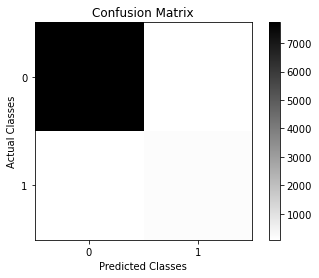

In [ ]:
cm.plot()

### Overall CM Statistics

In [ ]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.97741
F1 Macro                                                          0.83046
FPR Macro                                                         0.1583
Kappa                                                             0.66094
Overall ACC                                                       0.97741
PPV Macro                                                         0.82001
SOA1(Landis & Koch)                                               Substantial
TPR Macro                                                         0.8417
Zero-one Loss                                                     183

Class Statistics :

Classes                                                           0             1             
ACC(Accuracy)                                                     0.97741       0.97741       
AUC(Area under the ROC curve)                                     0.8417        0.8417        
AUCI(AU

In [ ]:
print(cm.overall_stat["F1 Macro"], cm.overall_stat["F1 Micro"])

0.8304648383525752 0.9774074074074074


In [ ]:
for threshold in np.arange(0.94, 0.98, 0.001):
    predict_vector = (similarities > threshold) * 1
    cm = ConfusionMatrix(actual_vector, predict_vector)
    print(threshold, cm.overall_stat["F1 Macro"], cm.overall_stat["F1 Micro"])

0.94 0.7913354942818189 0.9608641975308642
0.941 0.7983927190628055 0.9630864197530864
0.942 0.8026307578657972 0.9645679012345679
0.943 0.807880126861607 0.9665432098765432
0.944 0.8144344734480482 0.9685185185185186
0.945 0.8123615449979276 0.9690123456790124
0.946 0.8168362627197039 0.9701234567901235
0.947 0.8183565889351454 0.9708641975308642
0.948 0.8157670294096167 0.9707407407407408
0.949 0.8162340803233165 0.9714814814814815
0.95 0.8205240406626011 0.9729629629629629
0.951 0.821656098139149 0.9735802469135802
0.952 0.825639062200229 0.9745679012345679
0.953 0.8291569400024907 0.9754320987654321
0.954 0.8299338869879618 0.9760493827160494
0.955 0.8294688973725579 0.9762962962962963
0.956 0.834389400921659 0.9772839506172839
0.957 0.8304648383525752 0.9774074074074074
0.958 0.8250060116023926 0.9772839506172839
0.959 0.8251016681747159 0.9779012345679012
0.96 0.827173061641608 0.9786419753086419
0.961 0.8218404391661454 0.9783950617283951
0.962 0.8245987419133665 0.9791358024691